In [1]:
import torch
from mo_bayes_opt import MultiObjectiveBO

def joint_objective(x):
    x1 = x[:, 0]
    x2 = x[:, 1]
    interaction = torch.sin(5 * torch.pi * x1 * x2)
    f1 = ((x[:, :3] * torch.sin(3 * torch.pi * x[:, :3])).sum(dim=-1) + 0.5 * interaction)
    f2 = (((1 - x[:, 3:]) * torch.cos(3 * torch.pi * x[:, 3:])).sum(dim=-1) - 0.3 * interaction)
    return torch.stack([f1, f2], dim=-1)

def robust_joint_objective(x, epsilon=0.05, num_samples=10, mode='mean'):
    """
    Robustified joint objective with input perturbations.
    
    Args:
        x: Tensor of shape [N, D]
        epsilon: Size of perturbation (e.g., 0.05 means ±5% uniform noise)
        num_samples: Number of perturbed samples per input point
        mode: 'mean' for average performance (stability),
              'min' for worst-case performance (safety)
              
    Returns:
        Tensor of shape [N, 2] – robustified objectives
    """
    N, D = x.shape
    # Create [N, num_samples, D] perturbations
    noise = epsilon * (2 * torch.rand(N, num_samples, D) - 1)
    x_perturbed = x.unsqueeze(1) + noise
    x_perturbed = torch.clamp(x_perturbed, 0.0, 1.0)  # ensure within [0, 1]

    # Flatten for batch evaluation
    x_flat = x_perturbed.view(-1, D)
    
    # Evaluate original objective
    y_flat = joint_objective(x_flat)
    
    # Reshape back to [N, num_samples, 2]
    y = y_flat.view(N, num_samples, -1)

    # Aggregate
    if mode == 'mean':
        return y.mean(dim=1)
    elif mode == 'min':
        return y.min(dim=1).values
    else:
        raise ValueError(f"Unsupported mode: {mode}. Use 'mean' or 'min'.")

In [2]:
input_dim = 2

bo = MultiObjectiveBO(
    objective_fn=lambda x: robust_joint_objective(x, epsilon=0.05, num_samples=10, mode='mean'),
    input_dim=input_dim,
    bounds=torch.tensor([[0.0] * input_dim, [1.0] * input_dim]),
    ref_point=torch.tensor([-1.0, -1.0]),
    strategy="EHVI",
    use_adaptive_noise=False,
    save_models=True,
)

In [3]:
hypervolumes = bo.run(num_repeats=1, num_queries=100)


Trial 0


100%|██████████| 100/100 [01:57<00:00,  1.17s/it]


In [4]:
logger = bo.logger
history = logger.get_history()
models = history[0][-1]["models"]
# 假设你已经训练好最后一个模型：
model1 = models[0]  # or model2
model2 = models[1]

In [5]:
# predict_x = torch.concat([X.flatten().unsqueeze(-1), Y.flatten().unsqueeze(-1)], dim=-1)
# # pred_mean, pred_std = model.predict_mean_std(predict_x)

In [6]:
# predict_x.shape

In [7]:
def predict_matrix(model, X, Y):
    predict_x = torch.concat([X.flatten().unsqueeze(-1), Y.flatten().unsqueeze(-1)], dim=-1)
    pred_mean, pred_std = model.predict_mean_std(predict_x)
    pred_mean = pred_mean.reshape(X.shape[0], X.shape[1])
    pred_std = pred_std.reshape(X.shape[0], X.shape[1])
    return pred_mean, pred_std

test_x = torch.linspace(0, 1, 100).unsqueeze(-1).repeat(1, input_dim)  # 100 个点
X, Y = torch.meshgrid(test_x[:, 0], test_x[:, 1], indexing='ij')
Z = joint_objective(torch.stack([X.flatten(), Y.flatten()], dim=-1)).reshape(X.shape[0], X.shape[1], -1)

pred1_mean, pred1_std = predict_matrix(model1, X, Y)
pred2_mean, pred2_std = predict_matrix(model2, X, Y)

#### prediction

In [8]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'X2')

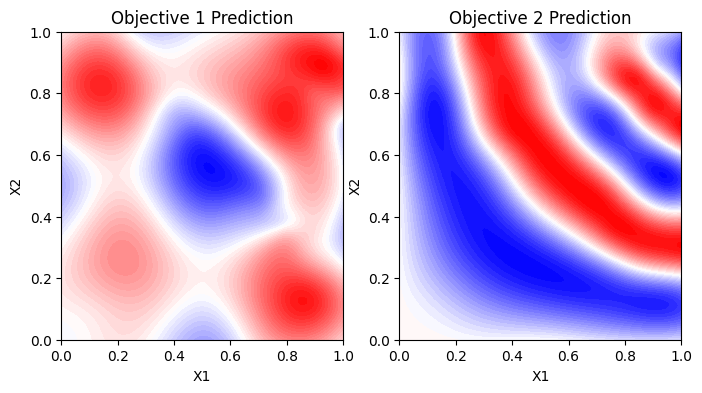

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
# 绘制第一个目标函数的预测
axs[0].contourf(X.numpy(), Y.numpy(), pred1_mean.numpy(), levels=50, cmap='bwr')
axs[0].set_title('Objective 1 Prediction')
axs[0].set_xlabel('X1')
axs[0].set_ylabel('X2')
# 绘制第二个目标函数的预测
axs[1].contourf(X.numpy(), Y.numpy(), pred2_mean.numpy(), levels=50, cmap='bwr')
axs[1].set_title('Objective 2 Prediction')
axs[1].set_xlabel('X1')
axs[1].set_ylabel('X2')

#### Function

Text(0, 0.5, 'X2')

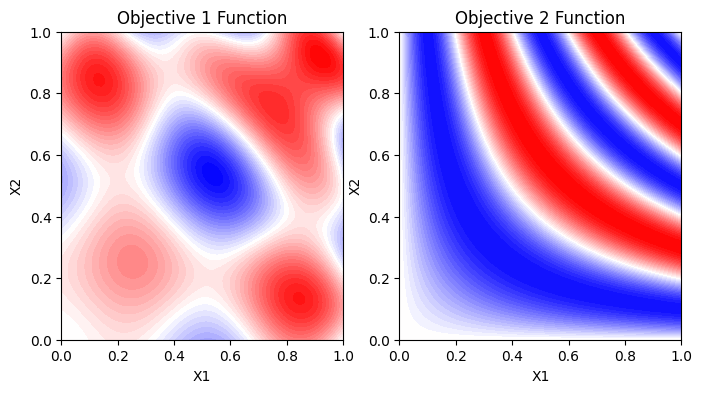

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
# 绘制第一个目标函数的预测
axs[0].contourf(X.numpy(), Y.numpy(), Z[:, :, 0].numpy(), levels=50, cmap='bwr')
axs[0].set_title('Objective 1 Function')
axs[0].set_xlabel('X1')
axs[0].set_ylabel('X2')
# 绘制第二个目标函数的预测
axs[1].contourf(X.numpy(), Y.numpy(), Z[:, :, 1].numpy(), levels=50, cmap='bwr')
axs[1].set_title('Objective 2 Function')
axs[1].set_xlabel('X1')
axs[1].set_ylabel('X2')